# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [93]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

import time

from torchvision import transforms

In [94]:
device = torch.device("cuda:0") # Let's make sure GPU is available!
torch.cuda.is_available()


False

# Загружаем данные

In [95]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [96]:
batch_size = 64

data_size = data_train.data.shape[0]
print("data_size",data_size)

#performance debug
data_size = int(np.floor(.01*data_size))

validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

data_size 73257


In [97]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [98]:
def compute_accuracy(model, val_loader):
    """
    Computes accuracy on provided data using mini-batches
    """
    total_samples = 0
    correct_samples = 0

    for i_step, (x, y) in enumerate(val_loader):

        x_gpu = x#.to(device)
        y_gpu = y#.to(device)
        predictions = model(x_gpu)    
        # print(prediction.shape, y_gpu.shape)
        # https://pytorch.org/docs/master/generated/torch.max.html
        values, indices = torch.max(predictions, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]


    accuracy = int(correct_samples) / total_samples
    return accuracy

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    start = time.time()
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x#.to(device)
            y_gpu = y#.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("epoch: %f Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))
        
    print("elapsed", time.time() - start, "seconds")
    return loss_history, train_history, val_history
        


# Подбор гиперпараметров

In [185]:
'''
channels1 = [32]
channels2 = [64]
channels3 = [128]
'''
channels1 = [32]
channels2 = [64]
channels3 = [128]

for channel1 in channels1:
    for channel2 in channels2:
        for channel3 in channels3:

            model = nn.Sequential(
                        nn.Conv2d(in_channels = 3, out_channels = channel1, kernel_size = 5, padding = 2), #C1
                        nn.AvgPool2d(kernel_size = 3),
                        #nn.MaxPool2d(kernel_size = 3), #S2
                        nn.BatchNorm2d(channel1),
                        nn.Conv2d(in_channels = channel1, out_channels = channel2,kernel_size = 5, padding = 2), #C3
                        nn.AvgPool2d(kernel_size = 3),
                        #nn.MaxPool2d(5),    #S4
                        nn.BatchNorm2d(channel2),
                        nn.Conv2d(in_channels = channel2, out_channels = channel3,kernel_size = 5, padding = 2), #C5
                        nn.BatchNorm2d(channel3),
                        nn.AvgPool2d(kernel_size = 3),
                        Flattener(),
                        nn.Linear(in_features=channel3, out_features=10), #F6
                        
                        #nn.BatchNorm1d(84),
                        #nn.ReLU(inplace=True),
                        #nn.Linear(84, 10)
                      )



            count = 0
            for i, (X, y) in enumerate(train_aug_loader):
                if i<1:
                    print(model(X).shape)
                break
                #count+=1
print(count)

torch.Size([32, 10])
0


In [189]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg', 'channel1', 'channel2', 'channel3', 'batch_size', 'hue', 'saturation', 'rotation'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])
'''
learning_rates = [2e-2]
anneal_coeff = 0.5
anneal_epochs = [9]
weight_decays = [ 1e-3]
'''

learning_rates = [2e-3]
anneal_coeff = 0.5
anneal_epochs = [9]
weight_decays = [ 1e-3]

batch_sizes = [32]
hues = [0]
saturations = [0]
rotations = [2]


# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

for channel1 in channels1:
    for channel2 in channels2:
        for channel3 in channels3:
            for learning_rate in learning_rates:
                for weight_decay in weight_decays:
                    for num_epoch in anneal_epochs:      
                        for batch_size in batch_sizes:
                            for hue in hues:
                                for saturation in saturations:
                                    for rotation in rotations:
                        
                        
                                        hyper = Hyperparams(learning_rate , num_epoch, weight_decay, 
                                                            channel1, channel2, channel3,
                                                           batch_size, hue, saturation, rotation)

                                        tfs_aug = transforms.Compose([
                                            transforms.ColorJitter(hue=hue, saturation=saturation),
                                            transforms.Grayscale(num_output_channels=3),
                                            #transforms.RandomHorizontalFlip(),
                                            #transforms.RandomVerticalFlip(),
                                            transforms.RandomRotation(rotation, resample=PIL.Image.BILINEAR),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.43,0.44,0.47],
                                                               std=[0.20,0.20,0.20])                           
                                        ])

                                        data_aug_train = dset.SVHN('./data/', 
                                                               transform=tfs_aug
                                                              )

                                        train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                                                                   sampler=train_sampler)
                                        
                                        model = nn.Sequential(
                                                    nn.Conv2d(in_channels = 3, out_channels = channel1, kernel_size = 5, padding = 2), #C1
                                                    nn.AvgPool2d(kernel_size = 3),
                                                    #nn.MaxPool2d(kernel_size = 3), #S2
                                                    nn.BatchNorm2d(channel1),
                                                    nn.Conv2d(in_channels = channel1, out_channels = channel2,kernel_size = 5, padding = 2), #C3
                                                    nn.MaxPool2d(5),    #S4
                                                    nn.BatchNorm2d(channel2),
                                                    nn.Conv2d(in_channels = channel2, out_channels = channel3,kernel_size = 5, padding = 2), #C5
                                                    nn.BatchNorm2d(channel3),
                                                    Flattener(),
                                                    nn.Linear(in_features=4*channel3, out_features=10) #F6
                                                    #nn.BatchNorm1d(84),
                                                    #nn.ReLU(inplace=True),
                                                    #nn.Linear(84, 10)
                                        )
                                        '''
                                        model = nn.Sequential(
                                            nn.Conv2d(in_channels = 3, out_channels = channel1, kernel_size = 5, padding = 2), #C1
                                            nn.AvgPool2d(kernel_size = 3),
                                            #nn.MaxPool2d(kernel_size = 3), #S2
                                            nn.BatchNorm2d(channel1),
                                            nn.Conv2d(in_channels = channel1, out_channels = channel2,kernel_size = 5, padding = 2), #C3
                                            nn.AvgPool2d(kernel_size = 3),
                                            #nn.MaxPool2d(5),    #S4
                                            nn.BatchNorm2d(channel2),
                                            nn.Conv2d(in_channels = channel2, out_channels = channel3,kernel_size = 5, padding = 2), #C5
                                            nn.BatchNorm2d(channel3),
                                            nn.AvgPool2d(kernel_size = 3),
                                            Flattener(),
                                            nn.Linear(in_features=channel3, out_features=10), #F6

                                            #nn.BatchNorm1d(84),
                                            #nn.ReLU(inplace=True),
                                            #nn.Linear(84, 10)
                                          )
                                        '''
                                        loss = nn.CrossEntropyLoss()

                                        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum= 0.8)
                                        #optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=anneal_coeff)
                                        
                                        print(hyper)

                                        loss_history, train_history, val_history = train_model(
                                            model, train_aug_loader, val_loader, loss, optimizer, num_epochs=num_epoch)

                                        run = RunResult(model, train_history, val_history, val_history[-1]) 

                                        run_record[hyper] = run
                                        

Hyperparams(learning_rate=0.002, anneal_epochs=9, reg=0.001, channel1=32, channel2=64, channel3=128, batch_size=32, hue=0, saturation=0, rotation=2)
epoch: 0.000000 Average loss: 2.407945, Train accuracy: 0.186007, Val accuracy: 0.328767
epoch: 1.000000 Average loss: 1.886706, Train accuracy: 0.404437, Val accuracy: 0.452055
epoch: 2.000000 Average loss: 1.435017, Train accuracy: 0.583618, Val accuracy: 0.568493
epoch: 3.000000 Average loss: 1.153849, Train accuracy: 0.653584, Val accuracy: 0.589041
epoch: 4.000000 Average loss: 0.929133, Train accuracy: 0.744027, Val accuracy: 0.636986
epoch: 5.000000 Average loss: 0.792230, Train accuracy: 0.798635, Val accuracy: 0.643836
epoch: 6.000000 Average loss: 0.681853, Train accuracy: 0.817406, Val accuracy: 0.589041
epoch: 7.000000 Average loss: 0.678308, Train accuracy: 0.815700, Val accuracy: 0.623288
epoch: 8.000000 Average loss: 0.510466, Train accuracy: 0.873720, Val accuracy: 0.643836
elapsed 22.725846529006958 seconds


0.19863013698630136
Best validation accuracy: 0.20, best hyperparams: Hyperparams(learning_rate=0.02, anneal_epochs=9, reg=0.001, channel1=32, channel2=64, channel3=128, batch_size=32, hue=0, saturation=0, rotation=2)


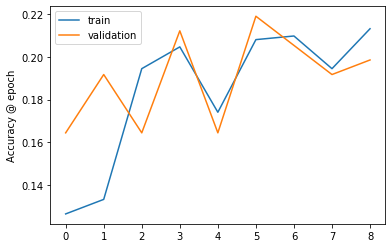

In [187]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    print(run_result.final_val_accuracy)
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

import matplotlib.pyplot as plt
def plot_history(train_history, val_history):
    
    # print("model summary:")
    # model = models.vgg16()
    # print(nn_model)
    
    # plt.plot(loss_history/np.mean(loss_history))
    plt.ylabel('Accuracy @ epoch')
    
    train, = plt.plot(train_history)
    train.set_label("train")
    validation, = plt.plot(val_history)
    validation.set_label("validation")

    plt.legend()
    plt.show()

plot_history(best_run.train_history, best_run.val_history, )

In [176]:
best_model = best_run.model
#best_model = lenet_model

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [177]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = 0.0

# Как всегда, в конце проверяем на test set


test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)


test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)

print("lenet accuracy", 0.8417716656422864)
print("Final test accuracy - ", final_test_accuracy)

lenet accuracy 0.8417716656422864
Final test accuracy -  0.6242701290719115
